<a href="https://colab.research.google.com/github/chi-hun/kaggle/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New York City Taxi Fare Prediction https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview

In [ ]:
# 한글 폰트 사용(폰트 다운)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] = False # -기호 깨짐 방지
import folium
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 데이터 로드(캐글 데이터 가져오기)

캐글에서 토큰 다운
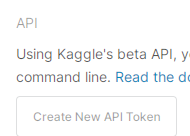

토큰 넣기

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huunnii","key":"70c5b2314ae139ef812cf3f144c8f227"}'}

업로드 잘됬는지 확인

In [ ]:
ls -1ha kaggle.json

kaggle.json


json 파일 이동

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

대회 데이터셋 불러오기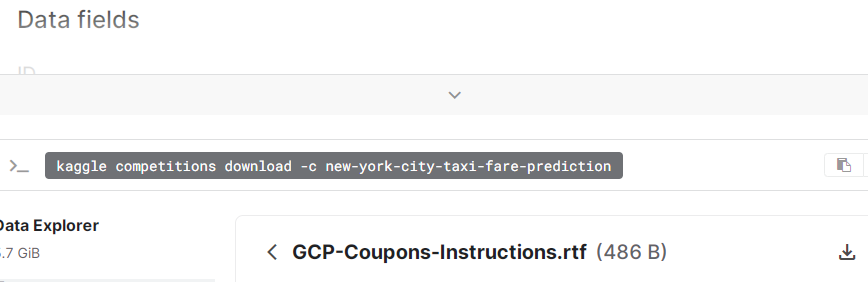

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

100% 1.56G/1.56G [00:20<00:00, 40.8MB/s]
100% 1.56G/1.56G [00:20<00:00, 80.9MB/s]


In [ ]:
!ls

kaggle.json  new-york-city-taxi-fare-prediction.zip  sample_data


압축되었을때

In [ ]:
!unzip /content/new-york-city-taxi-fare-prediction.zip

Archive:  /content/new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# EDA

In [ ]:
# train 데이터가 너무커서 제한
train = pd.read_csv('/content/train.csv', nrows=1000000)
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [ ]:
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

결측치 행 제외

In [ ]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                999990 non-null  object 
 1   fare_amount        999990 non-null  float64
 2   pickup_datetime    999990 non-null  object 
 3   pickup_longitude   999990 non-null  float64
 4   pickup_latitude    999990 non-null  float64
 5   dropoff_longitude  999990 non-null  float64
 6   dropoff_latitude   999990 non-null  float64
 7   passenger_count    999990 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 68.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [ ]:
x_train = train.copy()
y_train = x_train.pop('fare_amount')
x_test = test.copy()
x_train = x_train.drop('key', axis = 1)
x_test = x_test.drop('key', axis = 1)

날짜 처리(연, 월, 일(주말), 시간)

In [ ]:
x_train['year'] = pd.to_datetime(x_train['pickup_datetime']).dt.year
x_train['month'] = pd.to_datetime(x_train['pickup_datetime']).dt.month
x_train['weekday'] = pd.to_datetime(x_train['pickup_datetime']).dt.weekday
x_train['hour'] = pd.to_datetime(x_train['pickup_datetime']).dt.hour

In [ ]:
x_test['year'] = pd.to_datetime(x_test['pickup_datetime']).dt.year
x_test['month'] = pd.to_datetime(x_test['pickup_datetime']).dt.month
x_test['weekday'] = pd.to_datetime(x_test['pickup_datetime']).dt.weekday
x_test['hour'] = pd.to_datetime(x_test['pickup_datetime']).dt.hour

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


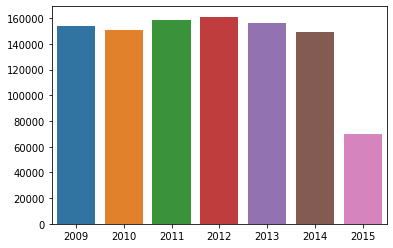

In [ ]:
sns.barplot(x_train.year.value_counts().index, x_train.year.value_counts().values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: Runt

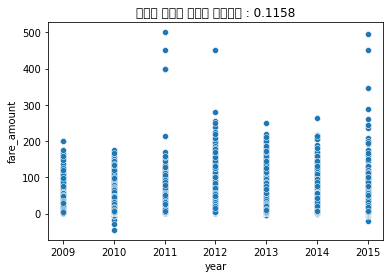

In [ ]:
year_sc = pd.concat([x_train['year'],y_train], axis = 1)
sns.scatterplot(year_sc['year'], year_sc['fare_amount'])
a = round(year_sc.corr()['year'][1],4)
plt.title(f'연도와 금액의 연관성 상관계수 : {a}')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


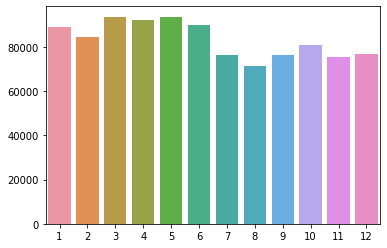

In [ ]:
sns.barplot(x_train.month.value_counts().index, x_train.month.value_counts().values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=fl

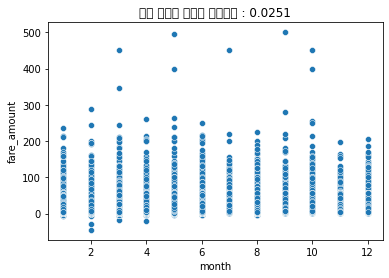

In [ ]:
month_sc = pd.concat([x_train['month'],y_train], axis = 1)
sns.scatterplot(month_sc['month'], month_sc['fare_amount'])
a = round(month_sc.corr()['month'][1],4)
plt.title(f'월과 금액의 연관성 상관계수 : {a}')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


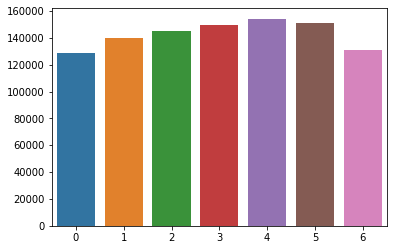

In [ ]:
sns.barplot(x_train.weekday.value_counts().index, x_train.weekday.value_counts().values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=fl

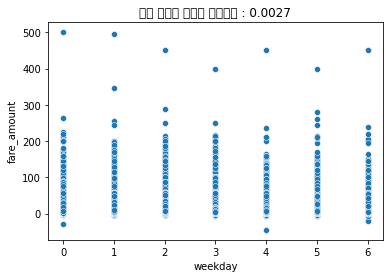

In [ ]:
weekday_sc = pd.concat([x_train['weekday'],y_train], axis = 1)
sns.scatterplot(weekday_sc['weekday'], weekday_sc['fare_amount'])
a = round(weekday_sc.corr()['weekday'][1],4)
plt.title(f'일과 금액의 연관성 상관계수 : {a}')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


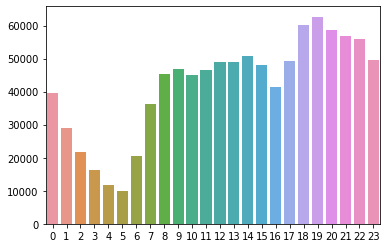

In [ ]:
sns.barplot(x_train.hour.value_counts().index, x_train.hour.value_counts().values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=fl

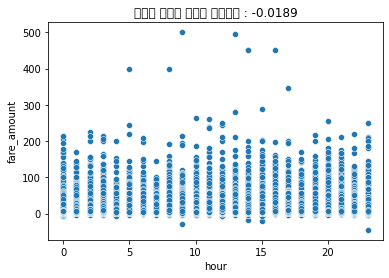

In [ ]:
hour_sc = pd.concat([x_train['hour'],y_train], axis = 1)
sns.scatterplot(hour_sc['hour'], hour_sc['fare_amount'])
a = round(hour_sc.corr()['hour'][1],4)
plt.title(f'시간과 금액의 연관성 상관계수 : {a}')
plt.show()

시간 범주화

In [ ]:
x_train['hour_b'] = pd.cut(x_train['hour'],bins = [-1,3,7,11,15,19,23], labels=[0,1,2,3,4,5]).astype('int64')
x_test['hour_b'] = pd.cut(x_test['hour'],bins = [-1,3,7,11,15,19,23], labels=[0,1,2,3,4,5]).astype('int64')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


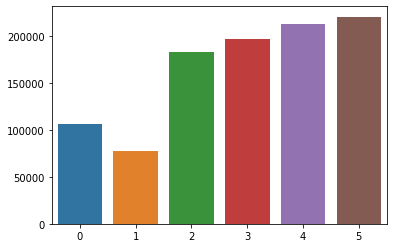

In [ ]:
sns.barplot(x_train.hour_b.value_counts().index, x_train.hour_b.value_counts().values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=fl

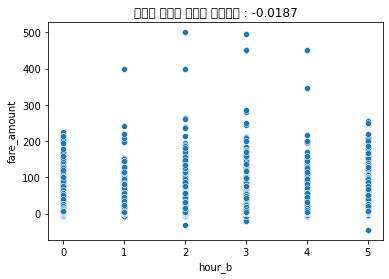

In [ ]:
hour_sc = pd.concat([x_train['hour_b'],y_train], axis = 1)
sns.scatterplot(hour_sc['hour_b'], hour_sc['fare_amount'])
a = round(hour_sc.corr()['hour_b'][1],4)
plt.title(f'시간과 금액의 연관성 상관계수 : {a}')
plt.show()

In [ ]:
x_train = pd.get_dummies(x_train, columns = ['hour_b'])
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    999990 non-null  object 
 1   pickup_longitude   999990 non-null  float64
 2   pickup_latitude    999990 non-null  float64
 3   dropoff_longitude  999990 non-null  float64
 4   dropoff_latitude   999990 non-null  float64
 5   passenger_count    999990 non-null  int64  
 6   year               999990 non-null  int64  
 7   month              999990 non-null  int64  
 8   weekday            999990 non-null  int64  
 9   hour               999990 non-null  int64  
 10  hour_b_0           999990 non-null  uint8  
 11  hour_b_1           999990 non-null  uint8  
 12  hour_b_2           999990 non-null  uint8  
 13  hour_b_3           999990 non-null  uint8  
 14  hour_b_4           999990 non-null  uint8  
 15  hour_b_5           999990 non-null  uint8  
dtypes:

In [ ]:
x_test = pd.get_dummies(x_test, columns = ['hour_b'])
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    9914 non-null   object 
 1   pickup_longitude   9914 non-null   float64
 2   pickup_latitude    9914 non-null   float64
 3   dropoff_longitude  9914 non-null   float64
 4   dropoff_latitude   9914 non-null   float64
 5   passenger_count    9914 non-null   int64  
 6   year               9914 non-null   int64  
 7   month              9914 non-null   int64  
 8   weekday            9914 non-null   int64  
 9   hour               9914 non-null   int64  
 10  hour_b_0           9914 non-null   uint8  
 11  hour_b_1           9914 non-null   uint8  
 12  hour_b_2           9914 non-null   uint8  
 13  hour_b_3           9914 non-null   uint8  
 14  hour_b_4           9914 non-null   uint8  
 15  hour_b_5           9914 non-null   uint8  
dtypes: float64(4), int64(5),

In [ ]:
hour_sc = pd.concat([x_train.loc[:,'hour_b_0':],y_train], axis = 1)
hour_sc.corr()['fare_amount'].abs().sort_values()

hour_b_5       0.010044
hour_b_0       0.010706
hour_b_4       0.012273
hour_b_3       0.015821
hour_b_2       0.019271
hour_b_1       0.026324
fare_amount    1.000000
Name: fare_amount, dtype: float64

거리를 어떤식으로 할까 고민(유클리드 거리, 맨허튼 거리) 맨허튼 거리로 결정

In [ ]:
x_train['m_uclid'] = (((x_train['dropoff_latitude'] - x_train['pickup_latitude']) ** 2) + ((x_train['dropoff_longitude'] - x_train['pickup_longitude']) ** 2))**0.5
x_test['m_uclid'] = (((x_test['dropoff_latitude'] - x_test['pickup_latitude']) ** 2) + ((x_test['dropoff_longitude'] - x_test['pickup_longitude']) ** 2))**0.5

In [ ]:
aa = pd.concat([x_train['m_uclid'],y_train], axis=1)
aa.corr()

,m_uclid,fare_amount
m_uclid,1.000000,0.008873
fare_amount,0.008873,1.000000


In [ ]:
x_train['m_menhunt'] = (x_train['dropoff_latitude'] - x_train['pickup_latitude']).abs() + (x_train['dropoff_longitude'] - x_train['pickup_longitude']).abs()
x_test['m_menhunt'] = (x_test['dropoff_latitude'] - x_test['pickup_latitude']).abs() + (x_test['dropoff_longitude'] - x_test['pickup_longitude']).abs()

In [ ]:
aa = pd.concat([x_train['m_menhunt'],y_train], axis=1)
aa.corr()

,m_menhunt,fare_amount
m_menhunt,1.000000,0.009099
fare_amount,0.009099,1.000000


In [ ]:
m = folium.Map(location=[x_train['pickup_latitude'][0], x_train['pickup_longitude'][0]],
               zoom_start=12, 
               width=750, 
               height=500
              )

In [ ]:
for i in range(10):
    folium.Marker([x_train['pickup_latitude'][i],  x_train['pickup_longitude'][i]]).add_to(m)
    folium.Marker([x_train['dropoff_latitude'][i],  x_train['dropoff_longitude'][i]], icon=folium.Icon('red')).add_to(m)
m

데이터 정리

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    999990 non-null  object 
 1   pickup_longitude   999990 non-null  float64
 2   pickup_latitude    999990 non-null  float64
 3   dropoff_longitude  999990 non-null  float64
 4   dropoff_latitude   999990 non-null  float64
 5   passenger_count    999990 non-null  int64  
 6   year               999990 non-null  int64  
 7   month              999990 non-null  int64  
 8   weekday            999990 non-null  int64  
 9   hour               999990 non-null  int64  
 10  hour_b_0           999990 non-null  uint8  
 11  hour_b_1           999990 non-null  uint8  
 12  hour_b_2           999990 non-null  uint8  
 13  hour_b_3           999990 non-null  uint8  
 14  hour_b_4           999990 non-null  uint8  
 15  hour_b_5           999990 non-null  uint8  
 16  m_

In [ ]:
x_train = x_train.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','hour','m_uclid'],axis=1)
x_test = x_test.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','hour','m_uclid'],axis=1)

이상치 제거

In [ ]:
x_train.describe()

,passenger_count,year,month,weekday,hour_b_0,hour_b_1,hour_b_2,hour_b_3,hour_b_4,hour_b_5,m_menhunt
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,1.684941,2011.741103,6.267841,3.039870,0.106543,0.078228,0.183810,0.196799,0.213581,0.221039,0.296264
std,1.323907,1.860761,3.436230,1.949966,0.308532,0.268530,0.387329,0.397579,0.409835,0.414947,14.429636
min,0.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2010.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015837
50%,1.000000,2012.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027638
75%,2.000000,2013.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050385
max,208.000000,2015.000000,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9726.488411


In [ ]:
x_train.loc[x_train['passenger_count'] == 0, 'passenger_count'] = 1

In [ ]:
x_train[x_train['passenger_count'] == 208]

,passenger_count,year,month,weekday,hour_b_0,hour_b_1,hour_b_2,hour_b_3,hour_b_4,hour_b_5,m_menhunt
929022,208,2009,7,3,0,0,1,0,0,0,0.0


In [ ]:
a = x_train[x_train['passenger_count'] == 208].index
x_train = x_train.drop(a)
y_train = y_train.drop(a)

In [ ]:
x_train['passenger_count'].value_counts()

1    694899
2    148105
5     70595
3     43765
4     21429
6     21196
Name: passenger_count, dtype: int64

In [ ]:
b = x_train[x_train['m_menhunt'] >1.5].index
x_train = x_train.drop(b)
y_train = y_train.drop(b)

In [ ]:
x_train.describe()

,passenger_count,year,month,weekday,hour_b_0,hour_b_1,hour_b_2,hour_b_3,hour_b_4,hour_b_5,m_menhunt
count,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000,997972.000000
mean,1.688291,2011.739191,6.267910,3.040000,0.106550,0.078218,0.183826,0.196810,0.213526,0.221070,0.043472
std,1.304416,1.860798,3.436485,1.949924,0.308541,0.268514,0.387342,0.397588,0.409796,0.414968,0.054445
min,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2010.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015817
50%,1.000000,2012.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027580
75%,2.000000,2013.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050145
max,6.000000,2015.000000,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.499698


In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997972 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  997972 non-null  int64  
 1   year             997972 non-null  int64  
 2   month            997972 non-null  int64  
 3   weekday          997972 non-null  int64  
 4   hour_b_0         997972 non-null  uint8  
 5   hour_b_1         997972 non-null  uint8  
 6   hour_b_2         997972 non-null  uint8  
 7   hour_b_3         997972 non-null  uint8  
 8   hour_b_4         997972 non-null  uint8  
 9   hour_b_5         997972 non-null  uint8  
 10  m_menhunt        997972 non-null  float64
dtypes: float64(1), int64(4), uint8(6)
memory usage: 51.4 MB


In [ ]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  9914 non-null   int64  
 1   year             9914 non-null   int64  
 2   month            9914 non-null   int64  
 3   weekday          9914 non-null   int64  
 4   hour_b_0         9914 non-null   uint8  
 5   hour_b_1         9914 non-null   uint8  
 6   hour_b_2         9914 non-null   uint8  
 7   hour_b_3         9914 non-null   uint8  
 8   hour_b_4         9914 non-null   uint8  
 9   hour_b_5         9914 non-null   uint8  
 10  m_menhunt        9914 non-null   float64
dtypes: float64(1), int64(4), uint8(6)
memory usage: 445.5 KB


표준화, 정규화

In [ ]:
sds, mms = StandardScaler(), MinMaxScaler()
for i in ['year','m_menhunt']:
    x_train[i] = sds.fit_transform(x_train[[i]])
    x_test[i] = sds.transform(x_test[[i]])
    x_train[i] = mms.fit_transform(x_train[[i]])
    x_test[i] = mms.transform(x_test[[i]])

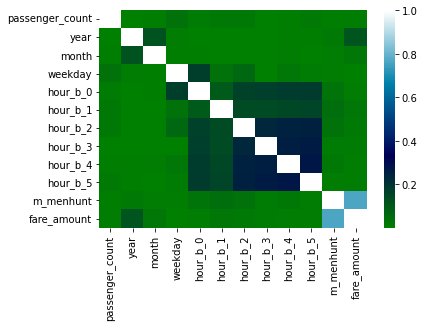

In [ ]:
xx = pd.concat([x_train, y_train], axis = 1)
sns.heatmap(xx.corr().abs(), cmap='ocean')
plt.show()

# 모델링(kneighbors, randomforest, xgb, ,lgbm, cat)

In [ ]:
# x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train, y_train)
knr = KNeighborsRegressor()
rfr = RandomForestRegressor(max_depth = 8, n_estimators = 300)
xgb = XGBRegressor(max_depth = 6, n_estimators = 100)
xgbrf = XGBRFRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
# models = [knr, rfr, xgb, xgbrf, lgbm, cat]
# for i in models:
#     model = i.fit(x_ttrain, y_ttrain)
#     pre = model.predict(x_ttest)
#     sc = round(model.score(x_ttrain, y_ttrain), 4)
#     mse = round(mean_squared_error(y_ttest, pre), 4)
#     print(f'{model.__class__.__name__} === sc : {sc}, mse : {mse}')

In [ ]:
params = {'max_depth' : [4], 'n_estimators' : [100]}
gsv = GridSearchCV(rfr, params, scoring='neg_mean_squared_error', cv = 5)
model = gsv.fit(x_train, y_train)
model.best_params_, model.best_score_

In [ ]:
params = {'max_depth' : [6], 'n_estimators' : [200]}
gsv = GridSearchCV(rfr, params, scoring='neg_mean_squared_error', cv = 5)
model = gsv.fit(x_train, y_train)
model.best_params_, model.best_score_

In [ ]:
params = {'max_depth' : [8], 'n_estimators' : [300]}
gsv = GridSearchCV(rfr, params, scoring='neg_mean_squared_error', cv = 5)
model = gsv.fit(x_train, y_train)
model.best_params_, model.best_score_

In [ ]:
params = {'max_depth' : [2,4,6], 'n_estimators' : [50,100,200]}
gsv = GridSearchCV(xgb, params, scoring='neg_mean_squared_error', cv = 5)
model = gsv.fit(x_train, y_train)
model.best_params_, model.best_score_

In [ ]:
params = {'max_depth' : [8,6], 'n_estimators' : [100]}
gsv = GridSearchCV(xgb, params, scoring='neg_mean_squared_error', cv = 5)
model = gsv.fit(x_train, y_train)
model.best_params_, model.best_score_

# 앙상블(rfr, xgb, cat)

In [56]:
model1 = rfr.fit(x_train, y_train)
pre1 = model1.predict(x_test)
model2 = xgb.fit(x_train, y_train)
pre2 = model2.predict(x_test)
model3 = cat.fit(x_train, y_train)
pre3 = model3.predict(x_test)
pre = (pre1 + pre2 + pre3)/3

[02:51:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [57]:
pre

array([10.10854387, 11.09378935,  4.69665376, ..., 54.26650986,
       24.25356247,  7.15806273])

In [59]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['fare_amount']=pre
submission.to_csv('submission.csv', index = False)